In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
import numba as nb
import random

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['agg.path.chunksize'] = 1e50

# Problem 1: PRNG

When plotting the 3D configuration of the pseudo-random numbers generated by the C standard library, we see that they in fact are not random at all and follow a pattern. Across many rotations of the 3D volume, we find correlations between entire portions of the generated number trios. Specifically, in the view provided below, we see that in fact the 3 pairs lie within about 30 planes (given by the roughly horizontal lines showing). It was hard to find an angle where the planes were fully visible but by shifting the viewing angle a little bit, we could see that the defined lines of the planes went all the way up and down. In addition, we can see there are also patterns going diagonal in the image, which we also wouldn't expect to see if we had a truly random generation of trios of numbers. 

Using python's random generator (random package), we see that the patterns are no longer there. Inspecting the 3D volume I couldn't find any angle on which the neighbouring trios of numbers seemed correlated. In addition to no harsh planes, I couldn't even find the smaller correlations that seemed to be everyone in the C generated numbers. 

This result obviously favours the python random generator as it will result in a distribution that is more close to a real random selection of numbers. Using the C standard generator guarantees that the numbers drawn from their distirbution will not be uniformly distributed within the box (as they can never live in the spaces between the planes) and therefore can really not be relied on for the purposes of randomly sampling a uniform 3D box. 

Unfortunately, I couldn't find a way to look for the same effect based on my computer's random number generator, as I kept running into an OSError (no such file). I'm unsure if I tried the wrong thing or if this really wasn't possible in this way for my machine. 

In [2]:
badpts = np.loadtxt('rand_points.txt')
x = badpts[:,0]
y = badpts[:,1]
z = badpts[:,2]

![Correlations](./correlations.png)

In [3]:
# generating trios of random numbers with python's random module

python_rand = []
for i in range(int(3e4)):
    python_rand.append(random.uniform(0, 1e8))

python_rand = np.array(python_rand)

python_rand = vv=np.reshape(python_rand,[int(1e4),3])

f=open('python_points.txt','w')
for i in range(python_rand.shape[0]):
    myline=repr(python_rand[i,0])+' '+repr(python_rand[i,1])+' '+ repr(python_rand[i,2])+'\n'
    f.write(myline)
f.close()

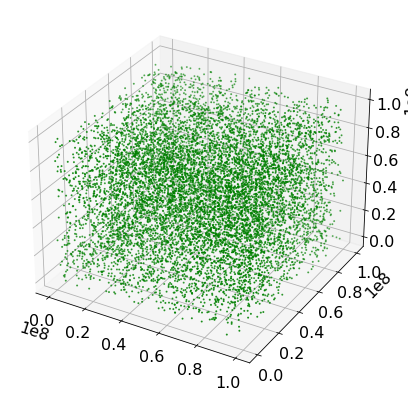

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(python_rand[:,0], python_rand[:,1], python_rand[:,2], s=1, color='green')

plt.show()

# Problem 2: Rejection method

In order to use the rejection method to uniformly sample exponential deviates, we need another distribution that meets the two requirements:

1. It is larger than the exponential at all points in the domain of interest
2. It is easy enough to generate uniform random numbers within that distribution

In the case of an exponential, we can immediately rule out the power law distribution. This is because we are looking at all regions of the exponential for $x \geq 0$ but the power law is undefined at $x = 0$ and it's area is unbounded as you approach $x = 0$. Therefore, the power law violates the first requirement. 

A Gaussian was harder to rule out. As long as you increased the width of the gaussian, it seemes like it could be larger than the exponential for all points, and it is certainly defined and bounded at all points that we cared about. However, with further inspection I noticed that even for very large $\sigma$, the exponential would eventually become larger than the Gaussian. This was by small amounts, which means that if we tried to use the rejection method for the exponential with the gaussian, the resulting distirbution might look okay but it would not in fact be correct. 

Finally, the Lorentzian satisfies both requirements and is therefore the distribution I used to get uniform exponential deviates using the rejection method. We see in the first plot below how the lorentzian is always larger than the exponential in the desired domain. Also a good thing to notice is the areas under their curves are not extremely dissimilar, which is good for the efficiency of our rejection sampler. 

In order to actually perform the rejection method, I first generated $n = 300000$ random numbers uniformly distributed between 0 and 1. Then, I used the transformation method to get instead those numbers to be uniformly distributed below the lorentzian distribution. For the transformation, I used:

$$CDF(x) = \int_0^x \frac{dx}{1+x^2} = arctan(x)$$

Then, we require that $CDF(-\infty) = 0$, $CDF(\infty) = 1$, so we rescale this to:

$$CDF(x) = \frac{1}{\pi}arctan(x) - \frac{1}{2}$$

Then, rearanging, we have that for each random number uniformy distributed between 0, 1: $x$, the new number following the lorentzian distribution is given by:

$$y = tan\left(\pi\left(x - \frac{1}{2}\right)\right)$$

From these numbers $y$, I then accept any that satisfy the condition $u < \frac{f}{cg}$, where $u$ is a separate uniform number between 0 and 1, $f$ is the value of the exponential at point $y$ and $g$ is the value of the lorentzian and point $y$. The factor of $c$ is always larger than $0$ and is tuned in order to reach a good result that has a high efficienty. 

While I was testing, I saw that any value of $c < 1$ would result in a distribution that did not look like what I expected, with visible gaps. Values of $c > 1$ looked like what I expected but had diminishing efficiency as they got larger. I therefore concluded that $c = 1$ likely produced the most efficient result in using the rejection method in this case. Below we see the distribution that it produced and we see it matched very well with the expected. The efficiency turned out to be $\eta \approx 64\%$ with this configuration.

In [11]:
x = np.linspace(0.001, 10, 1000)
expo = np.exp(-x)
lorentzian = 1 / (x**2+1)

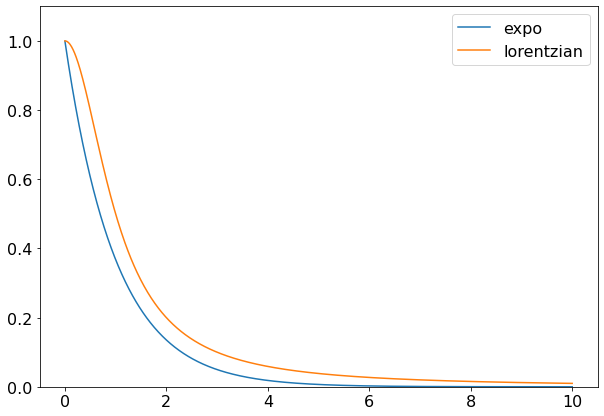

In [12]:
plt.figure()
plt.plot(x, expo, label='expo')
plt.plot(x, lorentzian, label='lorentzian')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

In [13]:
numbers = np.random.rand(300000)
lor_nums = np.tan(np.pi*(numbers - 1/2))

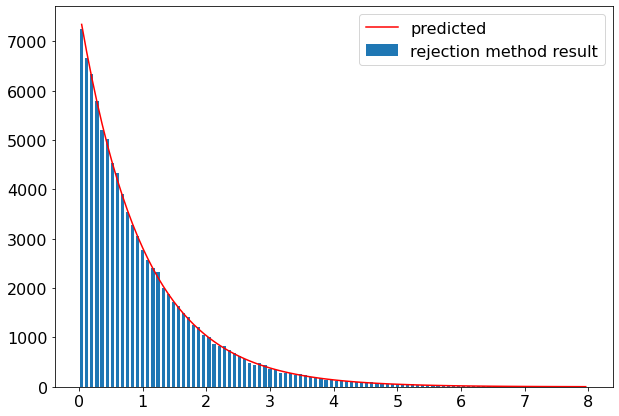

efficiency = 0.64 for c = 1


In [15]:
c = 1
accept = 0
total = 0
exp_dev_lor = []
for num in lor_nums[lor_nums >= 0]:
    total += 1
    u = np.random.rand()
    f = np.exp(-num)
    g = 1 / (num**2+1)
    if u <= f / (c*g):
        accept += 1
        exp_dev_lor.append(num)

a,b=np.histogram(exp_dev_lor,100,range=(0, 8))
bb=0.5*(b[1:]+b[:-1])
pred=np.exp(-bb)*np.sum(accept)*(bb[2]-bb[1])
plt.bar(bb,a,0.05, label='rejection method result')
plt.plot(bb,pred,'r', label='predicted')
plt.legend()
plt.show()

print('efficiency = {} for c = {}'.format(round(accept / total, 2), c))

# Problem 3: ratio-of-uniforms generator

Now we used the ratio-of-uniforms method. For this method, u usually goes from $0$ to $1$ and the $u,v$ plane from which we sample forms a sort of teardrop surface (as you can see in the plot below).

The requirements we have on $u$ are that it must satisfy $ 0< u < [p(v/u)]^{\frac{1}{2}}$. In this case we have:

$$u < [p(v/u)]^{\frac{1}{2}} = exp\left(-\frac{v}{2u}\right)$$

We can rearrange this to find the maximum value of $v$,

$$log(u) = -\frac{v}{2u} \longrightarrow v = -2ulog(u)$$

With this, we see that the maximum value of $v$ is $v_{max} \approx 0.74$ and we would usually have $v$ going from the positive to the negative of thsis value. However, because we are sampling only the positive part of the exponential, we will take $0 < v \leq v_{max}$.

After performing the ratio-of-uniforms method, we see that the result does follow what we expect to see (see plot below), and the efficiency is $\eta = 67\%$, which is a bit higher than we got with the rejection method and required a lot less work (at least to set up). 

max v is  0.7357588428385197


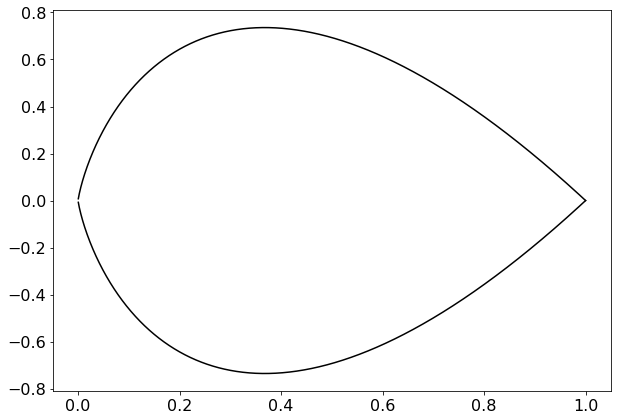

In [16]:
u = np.linspace(0,1,2001)
u = u[1:]

#u < exp(-r/2)
#log(u)=-v/2u
#v=-2u*(log(u))

v = -2*u*np.log(u)
print('max v is ',v.max())

plt.plot(u,v,'k')
plt.plot(u,-v,'k')
plt.show()

N = 1000000
u = np.random.rand(N)
v = (np.random.rand(N))*0.75
r = v/u
accept = u < np.exp(-r/2)
y = r[accept]

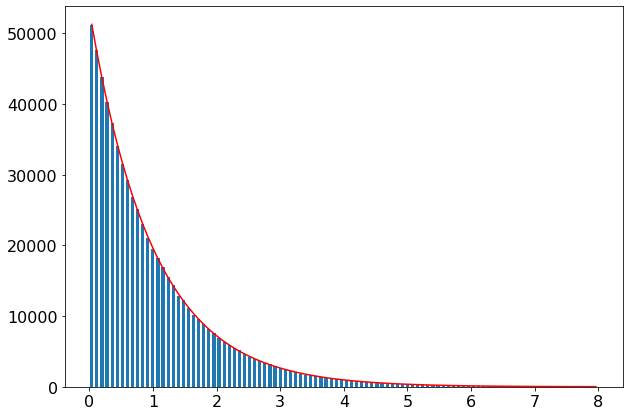

efficiency is = 0.67


In [17]:
a,b=np.histogram(y,100,range=(0, 8))
bb=0.5*(b[1:]+b[:-1])
pred=np.exp(-bb)*np.sum(accept)*(bb[2]-bb[1])
plt.bar(bb,a,0.05)
plt.plot(bb,pred,'r')
plt.show()

print('efficiency is =', round(np.count_nonzero(accept) / N, 2))